# Introduction

The purpose of this analysis is to answer 3 questions:

1. What is the tradeoff between model accuracy and the size of the training data set?
2. What is the tradeoff between model accuracy and the number of sensors used?
3. Does the accuracy of the sensors change over time?

Now we could argue that there is an additional question in regards to the interaction effect between the training size and the number of sensors. We can explore that question as well if time allows. So, now comes the most important question

__Why do we care about these questions?__  

The reason we care about the first question is because experimentation can be laborious and time consuming. We want to be able to start accurately predicting the chemicals to save precious time that could be better spent on something besides testing.

The reason we care about the second question is because the more sensors required in equipment using these sensors for processing the more expensive it will be.

The reason we care about third questions is because like everything phyisical in life, the sensors have a quantifiable usable life. Eventually, they will break down and no longer function. However, before the sensor completely fails, it will experience a decrease in performance at some unknown rate, typically known as drift. We would like to determine if there is any indication of drift occuring.

# Import Packages & Raw Data

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import graphviz

## Import Raw Data

In [2]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
d_path = base_fpath.replace('notebooks', 'data') #raw data file path

s_data = pd.read_csv(d_path + '/gas_data_cleaned.csv') #sensor data

# Split Data & Scale

## Split the Data

In order to answer questions 1 and 3 fron the introduction we need to split the data into three chucks: training, testing, and future. Training data will be used to determine how the data schould be scaled as well as fitting our model. We will eventually vary the amount of training data used to build our models with the test size variable in order to determine the tradeoff between number of experiments conducted and the accuracy of our predictions. Testing data will be used to score our models to help us determine if the model is good, while still being generalizable to new data. Future data will be the remaining data that is collected after our model is generated and will act as an additional means of determining goodness of fit and if any anomolies occur that could indicate system level changes.

In [3]:
#break the data into two subsets based on batch number
ind_vars = s_data.drop(columns=['ChemicalCode', 'Concentration', 'BatchNumber']).columns #column names of the independent variables
tt_data = s_data[s_data['BatchNumber'] <= 5] #train test data subset
f_data = s_data[s_data['BatchNumber'] > 5] #future data subset

#Break the data into independent and depedent variable groups
X_tt = tt_data[ind_vars] #train test independent variable data subset
y_tt_code = tt_data['ChemicalCode'] #train test 1st dependent variable
y_tt_con = tt_data['Concentration'] #train test 2nd dependent variable
X_f = f_data[ind_vars] #independent variable dataset
y_f_code = f_data['ChemicalCode'] #1st dependent variable
y_f_con = f_data['Concentration'] #2nd dependent variable

#Split the data
X_train, X_test, y_code_train, y_code_test = train_test_split(X_tt, y_tt_code, test_size=0.3, stratify=y_tt_code) #split the data into training and testing subsets

## Scale the Data

At this point we do not know the best method for scaling the data. We could use a normalizing method, standardize, or we could leave the data as is. The benefit of standardizing is that the data becomes unitless so we do not have to worry aobut units between independent variables. However, each of the independet variables should be using the same unit system even if they have different units. We also could leave the data as is, but this is typically considered bad practice since variables with larger values will automatically have a stronger influence on the model.

In order to determine which method might be best, lets test all of these scaling methods to determine if the method we select has a significant impact on model performance.

### Standardized

In [4]:
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

dt_ss = DecisionTreeClassifier(random_state=12)
dt_ss.fit(X_train_ss, y_code_train)
print(classification_report(y_code_test, dt_ss.predict(X_test_ss)))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       213
           2       0.98      1.00      0.99       302
           3       0.98      0.95      0.96       129
           4       0.95      0.97      0.96       136
           5       0.97      0.98      0.98       286
           6       0.88      0.88      0.88        24

    accuracy                           0.97      1090
   macro avg       0.96      0.95      0.96      1090
weighted avg       0.97      0.97      0.97      1090



### Min Max Scaled

In [5]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_test_mm = mm.transform(X_test)

dt_mm = DecisionTreeClassifier(random_state=12)
dt_mm.fit(X_train_mm, y_code_train)
print(classification_report(y_code_test, dt_mm.predict(X_test_mm)))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       213
           2       0.98      1.00      0.99       302
           3       0.98      0.95      0.96       129
           4       0.95      0.97      0.96       136
           5       0.97      0.98      0.98       286
           6       0.88      0.88      0.88        24

    accuracy                           0.97      1090
   macro avg       0.96      0.95      0.96      1090
weighted avg       0.97      0.97      0.97      1090



### Robust Scaler

In [6]:
rs = RobustScaler().fit(X_train)
X_train_rs = rs.transform(X_train)
X_test_rs = rs.transform(X_test)

dt_rs = DecisionTreeClassifier(random_state=12)
dt_rs.fit(X_train_rs, y_code_train)
print(classification_report(y_code_test, dt_rs.predict(X_test_rs)))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       213
           2       0.98      1.00      0.99       302
           3       0.98      0.95      0.96       129
           4       0.95      0.97      0.96       136
           5       0.97      0.98      0.98       286
           6       0.88      0.88      0.88        24

    accuracy                           0.97      1090
   macro avg       0.96      0.95      0.96      1090
weighted avg       0.97      0.97      0.97      1090



Overall the scaling methods don't seem to impact a basic decision trees ability to classify chemicals. When the random state of the decision tree is held constant, all scaling methods result in the same exact values for accuracy, precision and recall. Let's quickly check to see if these three methods impact the results we see compared to not scaling the data at all.

In [7]:
dt_raw = DecisionTreeClassifier(random_state=12)
dt_raw.fit(X_train, y_code_train)
print(classification_report(y_code_test, dt_raw.predict(X_test)))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       213
           2       0.98      1.00      0.99       302
           3       0.98      0.95      0.96       129
           4       0.95      0.97      0.96       136
           5       0.97      0.98      0.98       286
           6       0.88      0.88      0.88        24

    accuracy                           0.97      1090
   macro avg       0.96      0.95      0.96      1090
weighted avg       0.97      0.97      0.97      1090



The results are exactly the same even with the unprocessed data. In this case lets choose the robust scaler since we know from previous notebooks that we have high variance in our data with potential for outliers, and the robust scaler is better at reducing the impact of those outliers.

# Chemical Classification

## Baseline Models

We want to first create some models using simple rules to determine if the more complex models we are going to create actually improve our ability to predict the chemical sprecies. If our models do not improve our prediction ability significantly then we want to default to the simpler model, since simple models are easier to comprehend. Let's make two baseline models and pick whichever rule results in the best performance.

              precision    recall  f1-score   support

           1       0.18      0.14      0.16       213
           2       0.24      0.17      0.20       302
           3       0.10      0.13      0.12       129
           4       0.16      0.21      0.18       136
           5       0.26      0.17      0.21       286
           6       0.02      0.17      0.04        24

    accuracy                           0.16      1090
   macro avg       0.16      0.16      0.15      1090
weighted avg       0.20      0.16      0.18      1090



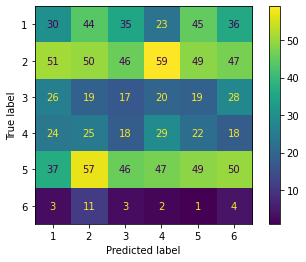

In [8]:
# Randomly Choose a Chemical Species
dc_rand = DummyClassifier(strategy = 'uniform', random_state=1991) #create a model that randomly chooses chemicals
dc_rand.fit(X_train_rs, y_code_train)
print(classification_report(y_code_test, dc_rand.predict(X_test_rs)))

ConfusionMatrixDisplay(confusion_matrix(y_code_test, dc_rand.predict(X_test_rs)), display_labels=dc_rand.classes_).plot() #display the confusion matrix
plt.show()

Using a random method we would expect the accuracy to be approximately 1 in 6 chance, 16.7%, of guessing the correct number. In this case we had a model accuracy of 18%, so slightly above theoretical. We could also create a model based on the most frequent chemical or account for the distribution of the chemicals tested. Let's use the most frequent method since the number of each chemical is not uniformly distributed.

In [9]:
# Always Choose the Most Frequent Chemical Species
dc_mf = DummyClassifier(strategy = 'most_frequent', random_state=1991) #create a model that chooses the most frequent chemical code in the training set
dc_mf.fit(X_train_rs, y_code_train)
print(classification_report(y_code_test, dc_mf.predict(X_test_rs)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       213
           2       0.28      1.00      0.43       302
           3       0.00      0.00      0.00       129
           4       0.00      0.00      0.00       136
           5       0.00      0.00      0.00       286
           6       0.00      0.00      0.00        24

    accuracy                           0.28      1090
   macro avg       0.05      0.17      0.07      1090
weighted avg       0.08      0.28      0.12      1090



C:\Users\sscov\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this case our accuracy is 28%, which is the heighest we've seen so far and we can use this model for our baseline performance.

## Advanced Model Creation

Since we will eventually want to vary our test size and reduce the number of features we use, let's create a function the mimics what we already did in a more streamlined fashion so we can create a for loop capable of providing us with answers to questions we had in the introduction.

### Model Prep Pipeline

In [10]:
def prep_data(data, targ_var, feat_list, test_size=0.3):
    """
    Inputs:
        data: full dataset. type = DataFrame
        y: dependent variable. type = String
        feat_list: subselection of independentt variables to use. type = list
        test_size: ratio of data from dataset to use for model validation. type = float
    Outputs:
        X_train: 
        X_test:
        y_train:
        y_test:
        X_f:
        y_f
    """
    data_tt = data[data['BatchNumber'] <= 5] #train test dataset
    y_tt = data_tt[targ_var]
    X_feats = data_tt[feat_list] #use the subselection of features
    X_train, X_test, y_train, y_test = train_test_split(X_feats, y_tt, test_size=test_size, stratify=y_tt) #split the data into a training and test set
    
    #Fture data to determine if drift occurs
    data_f = data[data['BatchNumber'] > 5]
    X_f = data_f[feat_list]
    y_f = data_f[targ_var]
    
    # scale the data
    rs = RobustScaler()
    rs.fit(X_train)
    X_train = pd.DataFrame(rs.transform(X_train), columns=feat_list)
    X_test = pd.DataFrame(rs.transform(X_test), columns=feat_list)
    X_f = pd.DataFrame(rs.transform(X_f), columns=feat_list)
    
    return X_train, X_test, y_train, y_test, X_f, y_f

### Feature List Creation

As you may we have a vary wide dataset with 128 independent variables. We will want to try to reduce that number for simplicity sake, and to answer question two from the introduction. Since there are 16 sensors and we do not want to test every single combination of each (there are 120 two sensor combinations), we will use a couple of combinations based on the sensor used from the features that were the most important when creating a basic decision tree. Any sensor that had a feature with importance >0.01 will be considered for the combinations.

In [11]:
#Determine which features were important for the quick decision tree classifier we made that had high accuracy
fi = dt_rs.feature_importances_
dt_feats = X_train.columns[fi > 0].tolist()
dt_feats = pd.DataFrame([dt_feats, fi[fi > 0]], index=['Variable', 'Importance'])
dt_feats = dt_feats.T
dt_feats.sort_values('Importance', ascending=False, inplace=True)
dt_feats[dt_feats['Importance'] >= 0.01]

,Variable,Importance
1,EMAd0.001_1,0.258151
5,EMAd0.1_2,0.194566
16,|DR|_7,0.163012
24,|DR|_10,0.097063
35,EMAi0.1_13,0.042441
15,EMAd0.1_6,0.027646
7,DR_4,0.026334
13,|DR|_6,0.022203
39,|DR|_16,0.019372
10,EMAi0.1_5,0.017421


Sensor 1, 2, 4, 5, 6, 7, 9, 10, 11 were all used in the model. However, we do not know if the important features changes every time we run the model so lets run a quick experiment. We will create a model 100 times and see how often each feature comes up as important

In [12]:
feats_imp_100 = []

for i in range(100):
    dt_rs_exp = DecisionTreeClassifier()
    dt_rs_exp.fit(X_train_rs, y_code_train)
    
    fi = dt_rs.feature_importances_
    dt_feats = X_train.columns[fi > 0].tolist()
    dt_feats = pd.DataFrame([dt_feats, fi[fi > 0]], index=['Variable', 'Importance'])
    dt_feats = dt_feats.T
    dt_feats.sort_values('Importance', ascending=False)
    imp_feats = dt_feats.Variable[dt_feats['Importance'] >= 0.01].tolist()
    feats_imp_100 = feats_imp_100 + imp_feats
    
feats_imp_100 = pd.Series(feats_imp_100)
feats_imp_100.value_counts(ascending=False)

EMAd0.001_1     100
EMAd0.1_2       100
DR_4            100
EMAi0.01_4      100
EMAi0.1_5       100
|DR|_6          100
EMAd0.1_6       100
|DR|_7          100
|DR|_9          100
EMAd0.1_9       100
|DR|_10         100
EMAd0.001_10    100
EMAi0.1_13      100
|DR|_16         100
dtype: int64

looks like those faetures were deemed important 100/100 times so lets only make combinations of sensors 1, 2, 4, 5, 6, 7, 9, 10, and 11.

In [13]:
ind_vars = ind_vars.tolist()
s1_feats = ind_vars[0:8]
s2_feats = ind_vars[8:16]
s4_feats = ind_vars[24:32]
s5_feats = ind_vars[32:40]
s6_feats = ind_vars[40:48]
s7_feats = ind_vars[48:56]
s9_feats = ind_vars[64:72]
s10_feats = ind_vars[72:80]
s11_feats = ind_vars[80:88]

combo_1 = s1_feats + s2_feats
combo_2 = s1_feats + s2_feats + s7_feats
combo_3 = s1_feats + s2_feats + s7_feats + s10_feats
combo_4 = s1_feats + s2_feats + s7_feats + s10_feats + s5_feats
combo_5 = s1_feats + s2_feats + s7_feats + s10_feats + s5_feats + s9_feats
combo_6 = s1_feats + s2_feats + s7_feats + s10_feats + s5_feats + s9_feats + s4_feats
combo_7 = s1_feats + s2_feats + s7_feats + s10_feats + s5_feats + s9_feats + s4_feats + s11_feats

lets now create a list of feature lists we want to use for our models. One other thing we want to try is doing PCA analysis for feature reduction.

In [14]:
full_set = ind_vars #use all 128 independent features
corr_set = pd.read_csv(d_path + '\CorrelationMethod/train.csv').columns.tolist() #use the features that have no correlation to each other from last notebook

feats_lists = [full_set, corr_set, s1_feats, combo_1, combo_2, combo_3, combo_4, combo_5 ,combo_6 ,combo_7, ['PCA']]
feats_names = ['full_set', 'corr_set', 's1_feats', 'combo_1', 'combo_2', 'combo_3', 'combo_4', 'combo_5', 'combo_6', 'combo_7', 'PCA']

### List of Models

It is never straightforward which type of model will perform best, so we should try multiple models. The models we will explore are: DecisionTree, RandomForest, KNN, LinearSVC, Gaussian Naive Bayes. Included decision tree and random forest classifier in case random forest does not provide a significant increase in model accuracy and we want to default to the easier to explain model. Logistic regression was not included in this set because our input data has some negative values and all values must be positive for logistic regression.

For now we will use the default hyperparameters and split the classifiers into two groups, the performers and non-performers.

In [15]:
#Create a list of the models we will experiment with
model_list = [DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LinearSVC(), GaussianNB()]

### Model Runs First Pass

In [16]:
cv_scores1 = []

for m in model_list:
    cv_scores1.append({m: cross_validate(m, X_train_rs, y_code_train)})
    
for m in cv_scores1:
    name = list(m.keys())
    scores = m[name[0]]
    print(name, end = '')
    for s, vals in scores.items():
        print(' ' + s + ': ' + str(np.mean(vals)), end = '')
    print('\n')

C:\Users\sscov\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sscov\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sscov\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sscov\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[DecisionTreeClassifier()] fit_time: 0.13022441864013673 score_time: 0.000995492935180664 test_score: 0.9712923286357377

[RandomForestClassifier()] fit_time: 0.7214631557464599 score_time: 0.01314091682434082 test_score: 0.9893840013613229

[KNeighborsClassifier()] fit_time: 0.03450851440429688 score_time: 0.053439998626708986 test_score: 0.979546896028959

[LinearSVC()] fit_time: 0.2721229553222656 score_time: 0.0013477802276611328 test_score: 0.9866273223705584

[GaussianNB()] fit_time: 0.005978822708129883 score_time: 0.0019411563873291016 test_score: 0.8014038643008524



C:\Users\sscov\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


So the Gaussian Naive bayes runs the quickest, but the accuracy is only ~80%. Overall, that is a pretty good score, especially compared to our baseline score of 28%, but it is still much worse than the other models. In this case we do not care too much about calculation speed so we can eliminate it as a potential model type. Otherwise, all other models seemed to perform similarily, with the fit time being the greatest for the random forest method, and basic decision tree classifier having just a slightly worse performance than the others. Another thing to note is that the SVM model failed to fully converge, yet it still seemed to produce good performance. To simplify let's only consider the random forest, KNN and Linear SVC models and we can increase the number of iterations for the next round.

### Model Runs Final

Now that we reduced the number of models lets answer questions one and two from the introduction by structuring our own gridsearch with our feature lists and test size list.

In [17]:
#Create a list of test sizes to use
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

#Create a list of the models we will experiment with
model_list = [RandomForestClassifier(), KNeighborsClassifier(), LinearSVC(max_iter=10000)]

#ignore convergence warnings
import warnings
warnings.filterwarnings("ignore")

cv_scores2 = []
for f in feats_lists:
    for ts in test_sizes:
        if 'PCA' in f:
            X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', full_set, ts)
            pca = PCA().fit(X_train)
            pca_var = pd.DataFrame(pca.explained_variance_ratio_)
            n_comps = len(pca_var[pca_var[0] >= 0.01])
            columns = ['comp'+str(i) for i in range(n_comps)]
            X_train = pd.DataFrame(PCA(n_components = n_comps).fit_transform(X_train), columns=columns)
        else:
            X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', f, ts)
            
        for m in model_list:
            scores = cross_validate(m, X_train, y_train)
            avg_scores = [np.mean(scores[k]) for k in scores.keys()] 
            cv_scores2.append({'model': m, 'feats': feats_names[feats_lists.index(f)], 'test_size': ts, 'avg_fit_time': avg_scores[0], 'avg_accuracy': avg_scores[2]})
        

In [18]:
perf_metrics = pd.DataFrame(cv_scores2) #convert our array of model metrics to a dataframe
for m in perf_metrics['model'].unique():
    model_metrics = perf_metrics[perf_metrics['model'] == m]
    print(m, np.mean(model_metrics['avg_accuracy']))

RandomForestClassifier() 0.946930762239928
KNeighborsClassifier() 0.937152626972565
LinearSVC(max_iter=10000) 0.9055936857843366


Among all the various combinations of features and test sizes, the random forest calssifier outperformed teh rest. Now witht he case of the LinearSVC, perhaps it did not perform as well because it never converged. For now lets only look at the Random Forest classifier results.

### Plot the Results

<AxesSubplot:xlabel='test_size'>

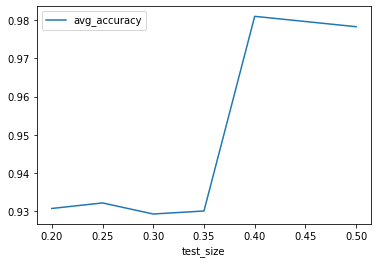

In [19]:
rf_metrics = perf_metrics[perf_metrics['model'] == perf_metrics.iloc[0,0]].copy()
rf_metrics.drop(columns='model', inplace=True)
test_size = rf_metrics.groupby('test_size')['avg_accuracy'].mean()
test_size = pd.DataFrame(test_size)

test_size.plot()

oddly enough we don't see any trend in the accuracy vs. the test size. this could be due to confounding with the used features as well. Let's now look at how used features impact accuracy.

In [20]:
feat_metrics = rf_metrics.groupby('feats')['avg_accuracy'].mean()
feat_metrics = pd.DataFrame(feat_metrics)
feat_metrics.sort_values('avg_accuracy',ascending=False)

,avg_accuracy
feats,
corr_set,0.988294
combo_7,0.988163
combo_4,0.987809
full_set,0.987684
combo_6,0.986731
combo_2,0.986411
combo_5,0.986256
combo_3,0.986239
combo_1,0.966666


For the most part the features set we use doesn't seem to impact the accuracy that greatly. Here we should note that once we start using three sensors (represented by combo_2), we no longer gain siginificant additional accuracy. Even so, only using one sensor still results in an accuracy of 96%. Let's now look once more at the affect of test size on the accuracy using our random forest classifier and create a final tradeoff curve to answer soem of our pertinent questions.

### Drift Detection

In [21]:
rf_models = []
test_scores = []

test_sizes = np.linspace(0.2, 0.99, 30)

for ts in test_sizes:
    X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', full_set, ts)
    rf = RandomForestClassifier(random_state=1991)
    rf.fit(X_train, y_train)
    test_scores.append({'test_size': ts, 'score':rf.score(X_test, y_test)})
    
test_scores = pd.DataFrame(test_scores)
test_scores.set_index('test_size', inplace=True)
test_scores.sort_index(inplace=True)

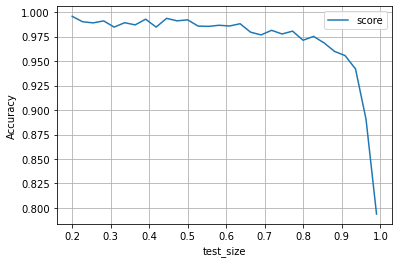

In [22]:
test_scores.plot()
plt.grid()
plt.ylabel('Accuracy')

plt.show()

So now we have a much better idea of the tradeoff between model accuracy and the number of experiments we have to run. At a test size of approximately 0.8 we start to see a steep decline in the accuracy, which equates to 727 experiments before we can start creating a model that is close to as acurate we can get. Now lets see what the long term performance of the model is like using a test size of 0.7. We will not be able to calculate a numerical drift value for this classification model, but what we can look at is the error rate and whether it changes over time or not.

## Final Tradeoff Chart

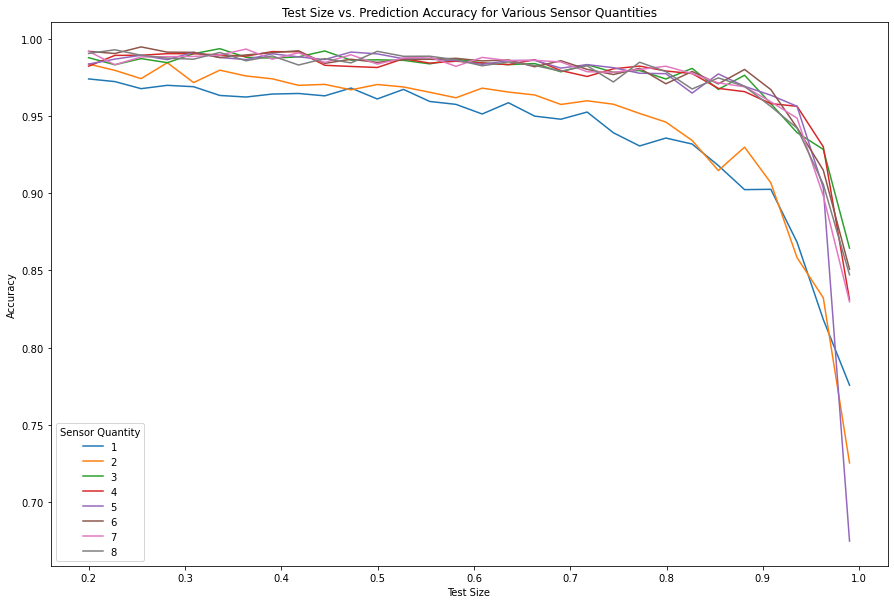

In [23]:
tradeoff_scores = []
num_sensors = [s1_feats, combo_1, combo_2, combo_3, combo_4, combo_5, combo_6, combo_7]

for ns in range(len(num_sensors)):
    for ts in test_sizes:
        X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', num_sensors[ns], ts)
        rf = RandomForestClassifier(random_state=1991)
        rf.fit(X_train, y_train)
        tradeoff_scores.append([ns+1, ts, rf.score(X_test, y_test)])
        
tradeoff_scores = pd.DataFrame(tradeoff_scores, columns=['Sensor Quantity', 'Test Size', 'Accuracy'])

fig = plt.figure(figsize=(15,10))
sns.lineplot(x='Test Size', y='Accuracy', data=tradeoff_scores, hue='Sensor Quantity', palette="tab10")
plt.title('Test Size vs. Prediction Accuracy for Various Sensor Quantities')

plt.show()

In [28]:
tradeoff_scores[tradeoff_scores['Accuracy'] > .99].sort_values(by=['Sensor Quantity', 'Test Size'])

,Sensor Quantity,Test Size,Accuracy
64,3,0.308966,0.990205
65,3,0.336207,0.993453
69,3,0.445172,0.991965
93,4,0.281724,0.990234
94,4,0.308966,0.990205
97,4,0.390690,0.991549
98,4,0.417931,0.991442
124,5,0.308966,0.991095
127,5,0.390690,0.990141
130,5,0.472414,0.991264


Based on these results, there are two potential solutions to that could balcne the desires of the suppliers and the consumers. 3 sensors witha  test size of .336207 or 5 sensors with a test size of .499655. Lets use the solution with the greater number of sensors to determine how the model performs over time and get the more detailed performance metrics.

## Drift Detection

In [39]:
X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', combo_4, 0.5)
rf = RandomForestClassifier().fit(X_train, y_train)
print('Test Classification Report')
print(classification_report(y_test, rf.predict(X_test)))

print('/n Future Classification Report')
print(classification_report(y_f, rf.predict(X_f)))

Test Classification Report
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       356
           2       0.99      1.00      1.00       503
           3       0.99      0.99      0.99       215
           4       0.98      0.97      0.98       228
           5       0.99      0.99      0.99       476
           6       0.97      1.00      0.99        39

    accuracy                           0.99      1817
   macro avg       0.99      0.99      0.99      1817
weighted avg       0.99      0.99      0.99      1817

/n Future Classification Report
              precision    recall  f1-score   support

           1       0.49      0.36      0.41      1854
           2       0.61      0.71      0.65      1921
           3       0.18      0.51      0.26      1210
           4       0.16      0.20      0.18      1481
           5       0.93      0.58      0.71      2057
           6       0.00      0.00      0.00      1754

    accuracy      

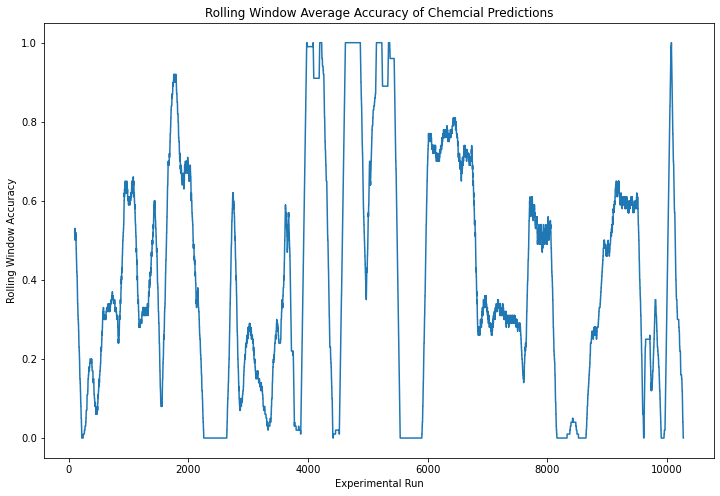

In [40]:
i_path = base_fpath.replace('notebooks', 'images')

y_f_pred = rf.predict(X_f)
error_rate = pd.concat([y_f.reset_index(), pd.DataFrame(y_f_pred, columns=['ChemicalPrediction'])], axis=1)
error_rate['error'] = error_rate['ChemicalCode'] == error_rate['ChemicalPrediction']

fig = plt.figure(figsize=(12,8))
plt.plot(error_rate['error'].rolling(100).mean())
plt.xlabel('Experimental Run')
plt.ylabel('Rolling Window Accuracy')
plt.title('Rolling Window Average Accuracy of Chemcial Predictions')

plt.savefig(i_path + '/future_accuracy.png')

We see now that there is a stark contrast between our test accuracy (.978) vs. our ongoing accuracy (.514). There are two possible reasons for why there is this difference. Either the system state changed after the batch 5 chemical tests (experimental setup, sensor drift, etc), or our model is not as good as we thought.

# Conclusion

So here are some answers to our questions:

1. What is the tradeoff between model accuracy and the size of the training data set?  
    __A__ We lose hardly any model test accuracy if we run at least 727 experiments
2. What is the tradeoff between model accuracy and the number of sensors used?  
    __A__ We have extremely good model accuracy if we use 4 sensors, with only minor accuracy loses from using a single sensor
3. Does the accuracy of the sensors change over time?  
    __A__ The accuracy of the model dramatically changes from our train/testing phase to our ongoing dataset. The reason as to why is currently unknown.

# Appendix

In [25]:
X_train, X_test, y_train, y_test, X_f, y_f = prep_data(s_data, 'ChemicalCode', full_set, ts)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
print(classification_report(y_test, xgb_model.predict(X_test)))
print(classification_report(y_f, xgb_model.predict(X_f)))

[09:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           1       0.46      0.74      0.57       704
           2       0.84      0.54      0.66       995
           3       0.62      0.65      0.63       427
           4       0.55      0.51      0.53       450
           5       0.91      0.87      0.89       943
           6       0.07      0.05      0.06        78

    accuracy                           0.66      3597
   macro avg       0.57      0.56      0.56      3597
weighted avg       0.70      0.66      0.67      3597

              precision    recall  f1-score   support

           1       0.57      0.35      0.44      1854
           2       0.48      0.02      0.03      1921
    